In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gc, tqdm, copy

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from functools import partial
from collections import defaultdict
import pandas as pd
import yaml
import os

2023-09-21 14:38:27.875912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 14:38:28.130703: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-21 14:38:33.194409: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/work/schreck/miniconda3/envs/evidential/lib/python3.10/site-packages/nvidia/cudn

### Load a configuation yaml 

In [2]:
config = "../config/surface_layer/mlp.yml"

In [3]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

### Load example training data (the full data set is available on Zenodo ... ) 

In [4]:
fn = "../data/sample_cabauw_surface_layer.csv"

In [5]:
input_cols = conf["data"]["input_cols"]
output_cols = ['friction_velocity:surface:m_s-1']

In [6]:
#data[["Time"]+input_cols+output_cols].sample(frac=0.1).to_csv("../data/sample_cabauw_surface_layer.csv")

In [7]:
data_seed = 0
flat_seed = 1000

n_splits = 1
n_models = 1

data = pd.read_csv(fn)
data["day"] = data["Time"].apply(lambda x: str(x).split(" ")[0])

# Need the same test_data for all trained models (data and model ensembles)
flat_seed = 1000
gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
splits = list(gsp.split(data, groups = data["day"]))
train_index, test_index = splits[0]
train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy() 

# Make N train-valid splits using day as grouping variable
gsp = GroupShuffleSplit(n_splits=n_splits,  random_state = flat_seed, train_size=0.885)
splits = list(gsp.split(train_data, groups = train_data["day"]))
train_index, valid_index = splits[data_seed]
train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy()  

In [8]:
x_scaler, y_scaler = RobustScaler(), MinMaxScaler((0, 1))
x_train = x_scaler.fit_transform(train_data[input_cols])
x_valid = x_scaler.transform(valid_data[input_cols])
x_test = x_scaler.transform(test_data[input_cols])

y_train = y_scaler.fit_transform(train_data[output_cols])
y_valid = y_scaler.transform(valid_data[output_cols])
y_test = y_scaler.transform(test_data[output_cols])

### 1. Deterministic multi-layer perceptron (MLP) to predict some quantity

In [9]:
from evml.keras.models import BaseRegressor as RegressorDNN
#from evml.keras.models import RegressorDNN
from evml.keras.callbacks import get_callbacks

/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [10]:
conf["model"]["epochs"] = 1
conf["model"]["verbose"] = 1

In [11]:
model = RegressorDNN(**conf["model"])
model.build_neural_network(x_train.shape[-1], y_train.shape[-1])

2023-09-21 14:38:40.093470: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [12]:
model.fit(
    x_train,
    y_train,
    validation_data=(x_valid, y_valid),
    callbacks=get_callbacks(conf, path_extend=f"")
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_00 (Dense)            (None, 500)               2500      
                                                                 
 dropout_h_00 (Dropout)      (None, 500)               0         
                                                                 
 dense_last (Dense)          (None, 1)                 501       
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
20/20 [==============================] - 1s 35ms/step - loss: 0.0649 - mae: 0.1535 - val_loss: 0.0067 - val_mae: 0.0472 - lr: 4.7274e-04


##### Predict with the model

In [13]:
y_pred = model.predict(x_test, y_scaler)

3/3 [==============================] - 0s 3ms/step


In [14]:
mae = np.mean(np.abs(y_pred[:, 0]-test_data[output_cols[0]]))

In [15]:
mae

0.06648637263594172

##### Create a Monte Carlo ensemble

In [16]:
monte_carlo_steps = 10

In [17]:
results = model.predict_monte_carlo(x_test, y_test, monte_carlo_steps, y_scaler)

In [18]:
mu_ensemble = np.mean(results, axis = 0)
var_ensemble = np.var(results, axis = 0)

In [19]:
mu_ensemble.shape

(7188, 1)

In [20]:
var_ensemble.shape

(7188, 1)

### 2. Predict mu and sigma with a "Gaussian MLP"

In [21]:
from evml.keras.models import GaussianRegressorDNN
#from evml.keras.models import GaussianRegressorDNN

In [22]:
config = "../config/surface_layer/gaussian.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)
    
conf["model"]["epochs"] = 1
conf["model"]["verbose"] = 1

In [23]:
gauss_model = GaussianRegressorDNN(**conf["model"])
gauss_model.build_neural_network(x_train.shape[-1], y_train.shape[-1])

In [24]:
gauss_model.fit(
    x_train,
    y_train,
    validation_data=(x_valid, y_valid),
    callbacks=get_callbacks(conf, path_extend=f"")
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_00 (Dense)            (None, 342)               1710      
                                                                 
 dropout_h_00 (Dropout)      (None, 342)               0         
                                                                 
 dense_01 (Dense)            (None, 342)               117306    
                                                                 
 dropout_h_01 (Dropout)      (None, 342)               0         
                                                                 
 DenseNormal (DenseNormal)   (None, 2)                 688       
                                                                 
Total params: 119,704
Trainable params: 119,702
Non-trainab

In [25]:
mu, var = gauss_model.predict_uncertainty(x_test, y_scaler)

3/3 [==============================] - 0s 8ms/step


In [26]:
# compute variance and std from learned parameters
#mu, var = gauss_model.calc_uncertainties(y_pred, y_scaler)

In [27]:
mae = np.mean(np.abs(mu[:, 0]-test_data[output_cols[0]]))
print(mae, np.mean(var) ** (1/2))

0.19325995681756414 0.07666676486741564


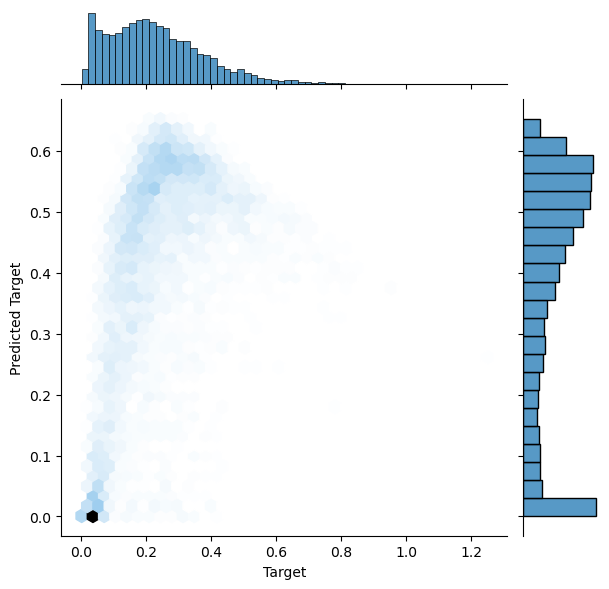

In [28]:
import seaborn as sns
sns.jointplot(x = test_data[output_cols[0]], y = mu[:, 0], kind = 'hex')
plt.xlabel('Target')
plt.ylabel('Predicted Target')
plt.show()

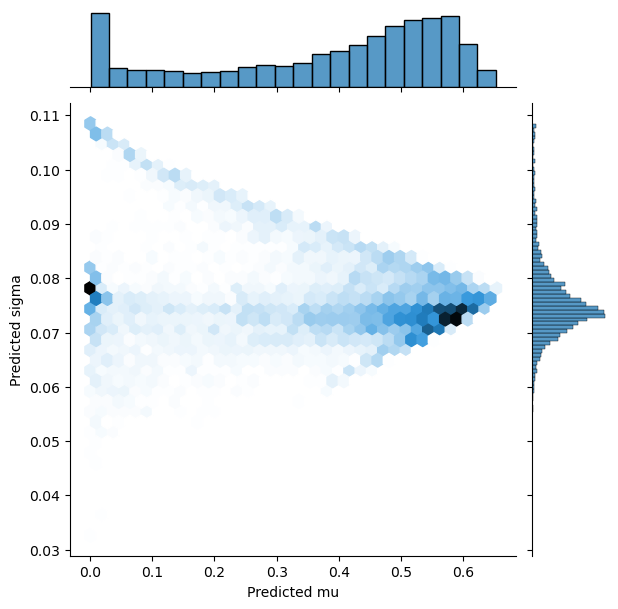

In [29]:
sns.jointplot(x = mu[:, 0], y = np.sqrt(var)[:, 0], kind = 'hex')
plt.xlabel('Predicted mu')
plt.ylabel('Predicted sigma')
plt.show()

### 3. Compute mu, aleatoric, and epistemic quantities using the evidential model

In [30]:
from evml.keras.models import EvidentialRegressorDNN

In [31]:
config = "../config/surface_layer/evidential.yml"

In [32]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)
    
conf["model"]["epochs"] = 5
conf["model"]["verbose"] = 1

In [33]:
ev_model = EvidentialRegressorDNN(**conf["model"])
ev_model.build_neural_network(x_train.shape[-1], y_train.shape[-1])

In [34]:
ev_model.fit(
    x_train,
    y_train,
    validation_data=(x_valid, y_valid),
    callbacks=get_callbacks(conf, path_extend=f""),
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_00 (Dense)            (None, 295)               1475      
                                                                 
 dropout_h_00 (Dropout)      (None, 295)               0         
                                                                 
 DenseNormalGamma (DenseNorm  (None, 4)                1188      
 alGamma)                                                        
                                                                 
Total params: 2,663
Trainable params: 2,659
Non-trainable params: 4
_________________________________________________________________
Epoch 1/5
12/12 [==============================] - 1s 46ms/step - loss: 9.5752 - mae: 0.1164 - val_loss: 5.4485 - val_mae: 

In [35]:
result = ev_model.predict_uncertainty(x_test, scaler=y_scaler)
mu, aleatoric, epistemic = result

2/2 [==============================] - 0s 5ms/step


In [36]:
mae = np.mean(np.abs(mu[:, 0]-test_data[output_cols[0]]))
print(mae, np.mean(aleatoric) ** (1/2), np.mean(epistemic) ** (1/2))

0.037156561226457434 0.05741469920663505 0.08447113752378002


In [37]:
from evml.regression_uq import compute_results

/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/evml/regression_uq.py:819: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


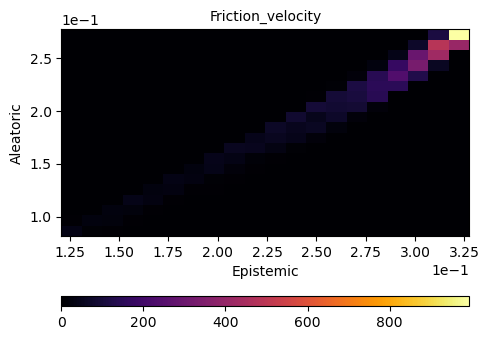

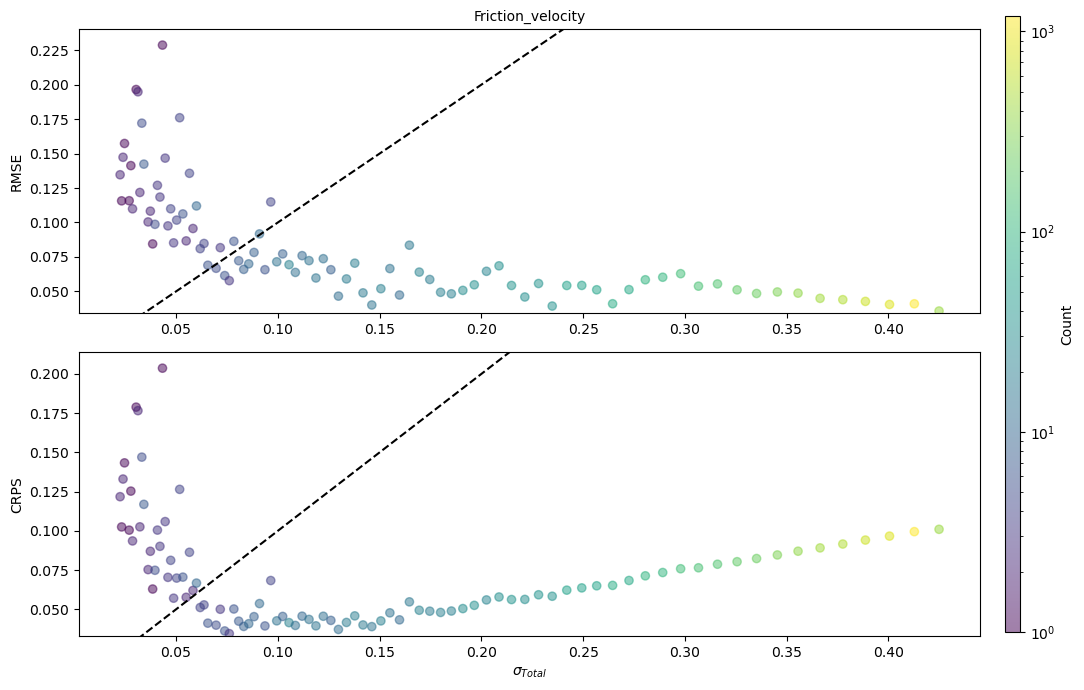

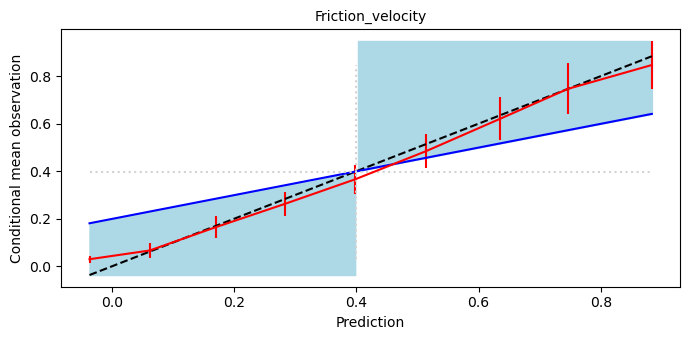

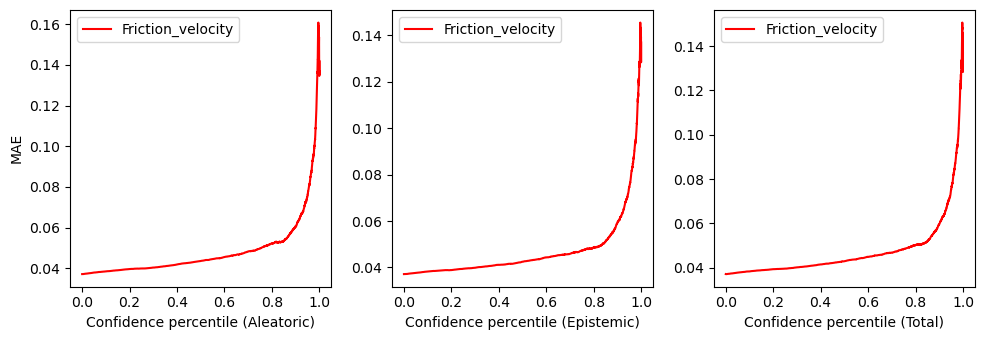

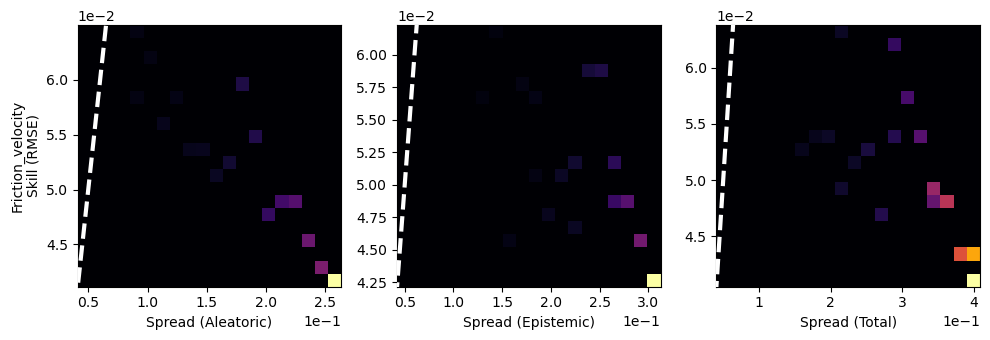

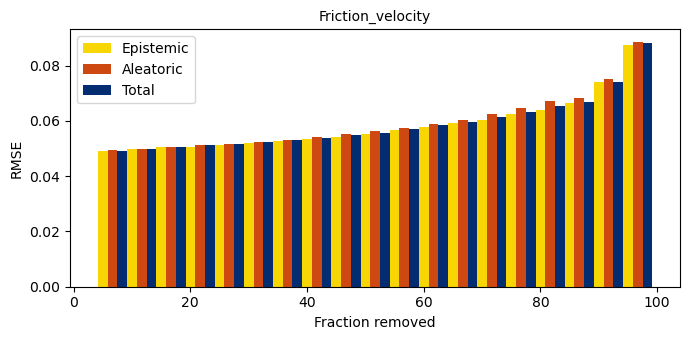

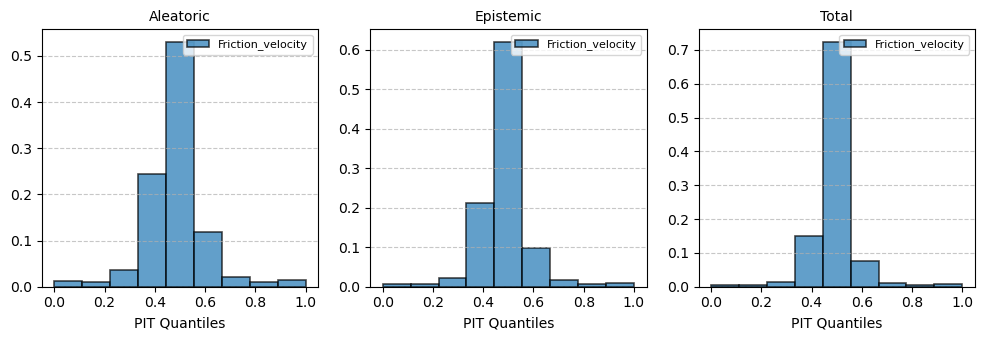

In [38]:
compute_results(test_data, output_cols, mu, np.sqrt(aleatoric), np.sqrt(epistemic))

### 4. Create a deep ensemble with the Gaussian model so that the law of total variance can be applied to compute aleatoric and epistemic

In [39]:
config = "../config/surface_layer/gaussian.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)
    
conf["save_loc"] = "./"
conf["model"]["epochs"] = 1
conf["model"]["verbose"] = 0
n_splits = conf["ensemble"]["n_splits"]

In [40]:
# make save directory for model weights
os.makedirs(os.path.join(conf["save_loc"], "cv_ensemble", "models"), exist_ok=True)

In [41]:
data_seed = 0
gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
splits = list(gsp.split(data, groups = data["day"]))
train_index, test_index = splits[0]

In [42]:
ensemble_mu = np.zeros((n_splits, test_data.shape[0], 1))
ensemble_var = np.zeros((n_splits, test_data.shape[0], 1))

for data_seed in tqdm.tqdm(range(n_splits)):
    data = pd.read_csv(fn)
    data["day"] = data["Time"].apply(lambda x: str(x).split(" ")[0])

    # Need the same test_data for all trained models (data and model ensembles)
    flat_seed = 1000
    gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
    splits = list(gsp.split(data, groups = data["day"]))
    train_index, test_index = splits[0]
    train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy() 

    # Make N train-valid splits using day as grouping variable
    gsp = GroupShuffleSplit(n_splits=n_splits,  random_state = flat_seed, train_size=0.885)
    splits = list(gsp.split(train_data, groups = train_data["day"]))
    train_index, valid_index = splits[data_seed]
    train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy()  

    x_scaler, y_scaler = RobustScaler(), MinMaxScaler((0, 1))
    x_train = x_scaler.fit_transform(train_data[input_cols])
    x_valid = x_scaler.transform(valid_data[input_cols])
    x_test = x_scaler.transform(test_data[input_cols])

    y_train = y_scaler.fit_transform(train_data[output_cols])
    y_valid = y_scaler.transform(valid_data[output_cols])
    y_test = y_scaler.transform(test_data[output_cols])
    
    model = GaussianRegressorDNN(**conf["model"])
    model.build_neural_network(x_train.shape[-1], y_train.shape[-1])
    
    model.fit(
        x_train,
        y_train,
        validation_data=(x_valid, y_valid),
        callbacks=get_callbacks(conf, path_extend=f"")
    )
    
    model.model_name = f"cv_ensemble/models/model_seed0_split{data_seed}.h5"
    model.save_model()
    
    # Save the best model 
    model.model_name = f"cv_ensemble/models/best.h5"
    model.save_model()
    
    mu, var = model.predict_uncertainty(x_test, y_scaler)
    mae = np.mean(np.abs(mu[:, 0]-test_data[output_cols[0]]))
    
    ensemble_mu[data_seed] = mu
    ensemble_var[data_seed] = var

  0%|          | 0/2 [00:00<?, ?it/s]

3/3 [==============================] - 0s 6ms/step


 50%|█████     | 1/2 [00:02<00:02,  2.46s/it]

3/3 [==============================] - 0s 6ms/step


100%|██████████| 2/2 [00:04<00:00,  2.39s/it]


##### Use the method predict_ensemble to accomplish the same thing given pretrained models:

In [43]:
model = GaussianRegressorDNN().load_model(conf)

In [44]:
#models = [f"./model_split{data_seed}.h5" for data_seed in range(n_splits)]
ensemble_mu, ensemble_var = model.predict_ensemble(x_test, scaler = y_scaler)

3/3 [==============================] - 0s 7ms/step


In [45]:
epistemic = np.var(ensemble_mu, axis=0)
aleatoric = np.mean(ensemble_var, axis=0)

In [46]:
print(epistemic.mean() ** (1/2), aleatoric.mean() ** (1/2))

0.013795540561833818 0.0748211942634483


/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/evml/regression_uq.py:819: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


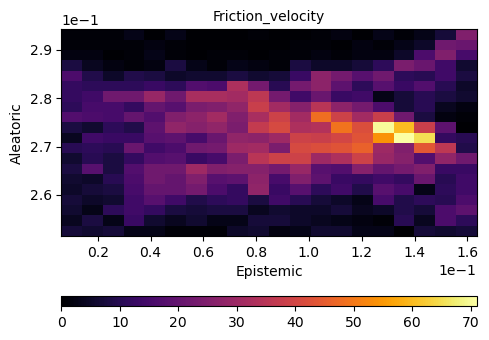

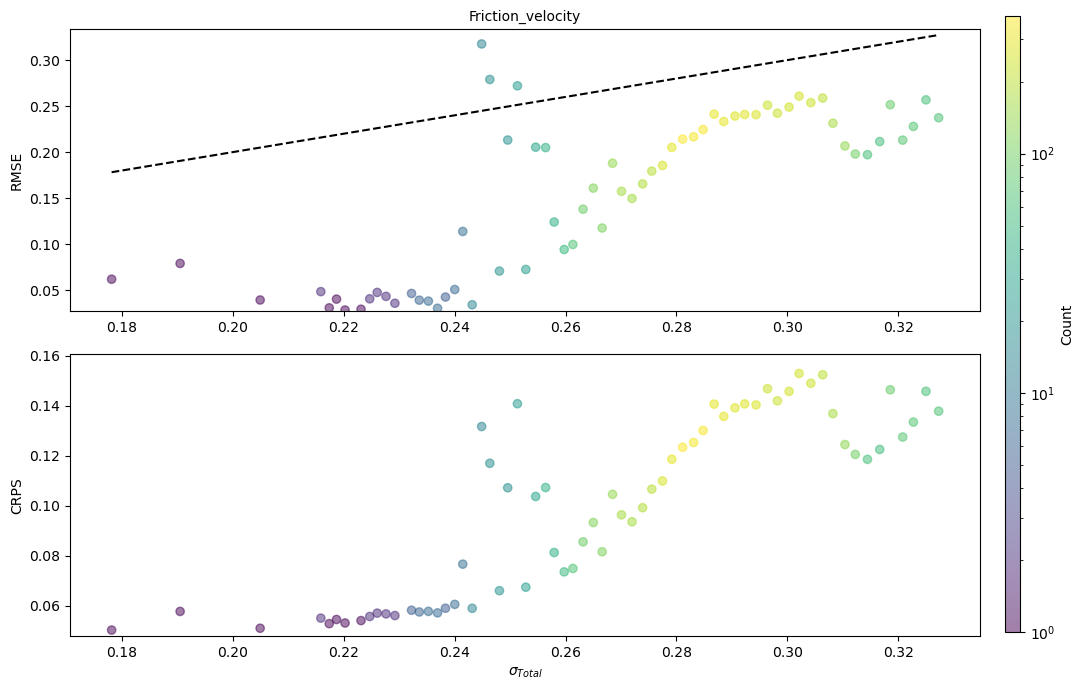

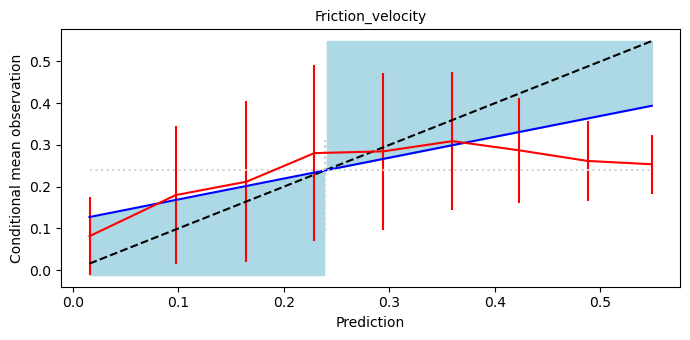

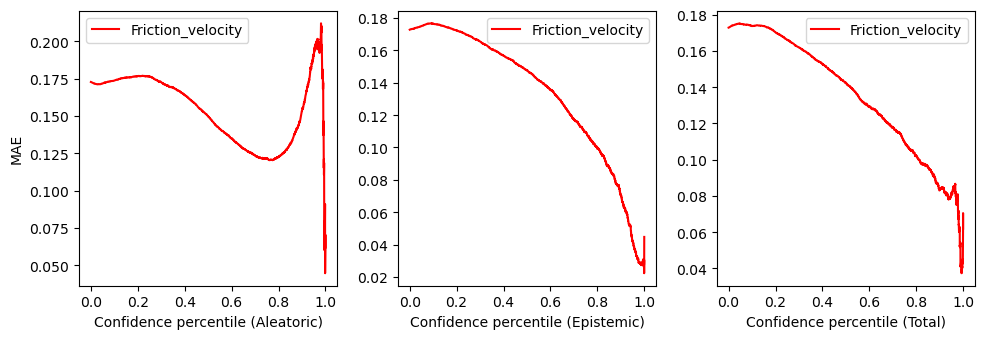

/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2168: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


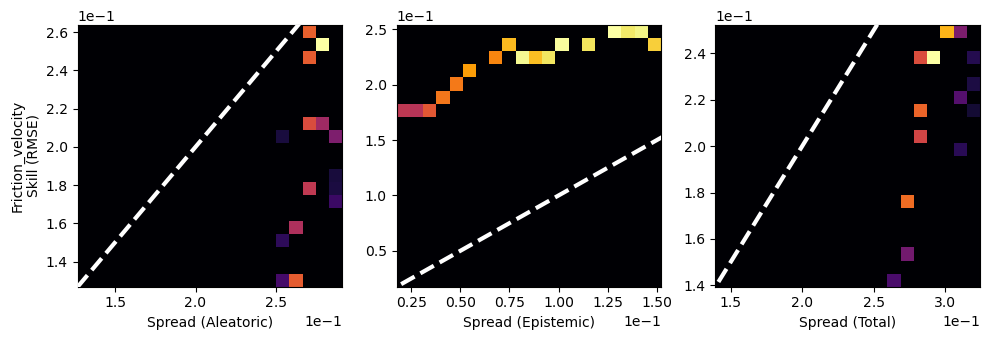

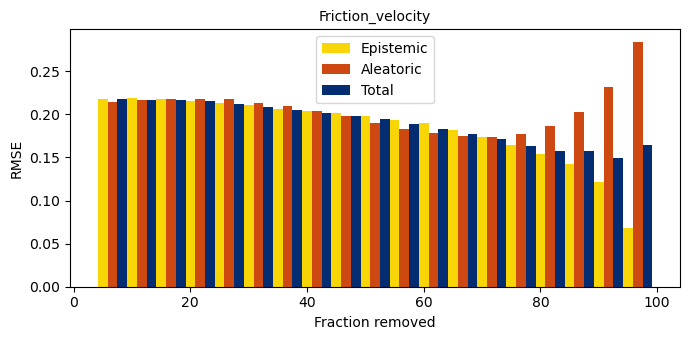

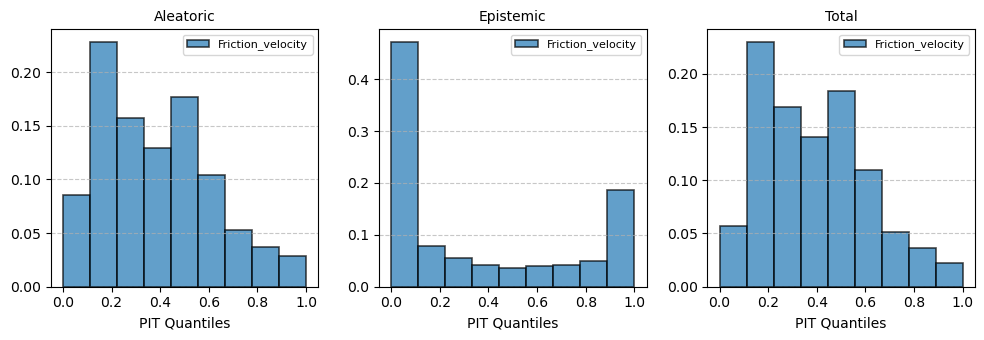

In [47]:
compute_results(test_data, output_cols, np.mean(ensemble_mu, axis=0), np.sqrt(aleatoric), np.sqrt(epistemic))

### 5. Use Monte Carlo dropout with the Gaussian model to compute aleatoric and epistemic uncertainties

In [50]:
monte_carlo_steps = 10

ensemble_mu, ensemble_var = model.predict_monte_carlo(x_test, y_test, monte_carlo_steps, scaler = y_scaler)

In [51]:
ensemble_epistemic = np.var(ensemble_mu, axis=0)
ensemble_aleatoric = np.mean(ensemble_var, axis=0)
ensemble_mean = np.mean(ensemble_mu, axis=0)